# Sequential Multi-Task Fine-tuing: BERT Fine-Tuning

## Introduction

This notebook fine-tunes a BERT model for the given dataset. One approach is to use a pre-trained model and fine-tune it directly on the given dataset. However, there are other fine-tuning approaches, such as Multi-Task fine-tuning [2]. In this notebook, in addition to finetuning directly on stackoverflow dataset, we adopt the Multi-Task fine-tuning approach. Specifically, we use a pre-trained BERT model and fine-tune it on a target domain — in our case, a dataset named Yahoo! Answers. This task involves question classification, similar to the exercise's task. Next, we utilize the fine-tuned model from the previous step and further fine-tune it on the main target dataset, which is the StackOverflow dataset.

Before going through the implementations, we explain the reason for the packages we imported. 

In [1]:
import pandas as pd # for reading the csv files.
from sklearn.model_selection import train_test_split # to split the validation set into two sets named validation and test.
import torch
from torch.utils.data import Dataset, DataLoader # To create dataset and loaders from train, validation, and test dataframes
'''
The Following imports are:
1- BertTokenizer is a tokenizer class specifically designed for BERT models. 
It handles the conversion of text into tokens, adding special tokens required by BERT, 
and creating input tensors needed for the model.
2- BertForSequenceClassification
3- AdamW: An extension of Adam optimizer with weight decay.
4- get_linear_schedule_with_warmup: we can set up a scheduler which warms up for num_warmup_steps and then linearly decays 
to 0 by the end of training.
'''
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")

# We check whether cuda is available or not.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Available device is ', device)


Available device is  cuda


### Loading Data

In [2]:
# Define a custom dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        #Utilizing the tokenzier specific for BERT
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True, # Add special tokens to the inputs of the BERT
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True, # The text is truncated if it exceeds the max length
            return_attention_mask=True, # a binary mask indicating which tokens are actual input tokens and which are padding tokens
            return_tensors='pt', # Return results with Tensor type
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initializing the tokenizer specific for pre-trained BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Creating data loaders
def create_data_loader(df, tokenizer, max_len, batch_size,target_label):
    dataset = TextDataset(
        texts=df['Text'].to_numpy(),
        labels=df[target_label].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(dataset, batch_size=batch_size, num_workers=2)


### Creating the model

In the following cell, we

1- creat the model

2- Creat the optimizer and adjust the learning rate scheduling. The hyperparameter seeting have been don based on the following paper [2]. 

Sun, Chi, et al. "How to fine-tune bert for text classification?." Chinese computational linguistics: 18th China national conference, CCL 2019, Kunming, China, October 18–20, 2019, proceedings 18. Springer International Publishing, 2019.
https://arxiv.org/pdf/1905.05583

In [3]:
# Here we define the model, we use pre-trained BERT speficied by 'bert-base-uncased'. We just change the head of the
# the model to produce three output in accordance with the number of classes in our datasets.
class BERTModel(object):
    def __init__(self,model_dir=None,num_classes=None):
        print('model_dir',model_dir)
        if model_dir is None:
            print('load pre-trained model')
            self.model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)  # num_classes is the number of classes
            # Move the model to GPU if available            
            self.model = self.model.to(device)
            
            # In this experiment, we freez the encoder part. To put it diffeently, we just train the head of the model. 
            # We can also fine-tune the whole model. However, since the model is fine-tuned and inorder to speed up fine-tuning we freez the base
            # of the model which is the encoder part.
            #for param in model.base_model.parameters():
             #   param.requires_grad = False
        else:
            self.model = BertForSequenceClassification.from_pretrained(model_dir)
            self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, num_classes)
            self.model = self.model.to(device)
            
        # Define the optimizer and the learning rate scheduler
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5, weight_decay=0.95)
        total_steps = len(train_data_loader) * num_classes  # num_classes is the number of epochs
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=total_steps)

### Train and Validation procedure

Here, we implement the common train and validation functions.


In [4]:
# Training function
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        #loss = outputs.loss # Computed based on biult in loss function. In this case crossentropy loss function
        loss = torch.nn.CrossEntropyLoss()(outputs.logits, labels)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    return correct_predictions.double().item() / len(data_loader.dataset), np.mean(losses).item()

# Validation function
def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )

            #loss = outputs.loss
            loss = torch.nn.CrossEntropyLoss()(outputs.logits, labels)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double().item() / len(data_loader.dataset), np.mean(losses).item()


### Training loop

This cells implements the training loop. Epochs specify the number of epochs the model sees the data.

We also collect statistics such as loss and accuracy for each of train, validation and test sets.

In [5]:

def Model_Training(EPOCHS,dataset_name,model,optimizer,scheduler):
    train_losses = []
    train_accs = []
    
    val_losses = []
    val_accs = []
    
    test_losses = []
    test_accs = []
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)
    
        train_acc, train_loss = train_epoch(model, train_data_loader, optimizer, device, scheduler)
        print(f'Train loss {train_loss} accuracy {train_acc}')
        train_losses.append(train_loss)
        train_accs.append(train_acc)
    
        val_acc, val_loss = eval_model(model, val_data_loader, device)
        print(f'Val   loss {val_loss} accuracy {val_acc}')
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        test_acc, test_loss = eval_model(model, test_data_loader, device)
        print(f'Test   loss {test_loss} accuracy {test_acc}')
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print()
    # Save model and tokenizer
    model.save_pretrained('./saved_model/'+dataset_name)
    print('model_saved')
    return (train_losses,train_accs,val_losses,val_accs,test_losses,test_accs)

# Start Training

In the following cell, you can start fine-tuning on different datasets. What we have followed is

1- Fine-tuning pre-trained BERT on YahooAnswers datasets

2- Finetuning the model from previous step on stackoverflow dataset.

3- Finetuning the pre-trained BERT directly on stackoverflow. 

In [6]:

# Parameters
EPOCHS = 3
MAX_LEN = 128 # Maximum length of sequence.
BATCH_SIZE = 16

# use one of options  'stackoverflow' or 'YahoAnswers'. If you select 'stackoverflow', please considered whether you have finetuned model 
# on YahooAnsers or not. If you don't have it, and you want to fine-tune directly on stackoverflow, uncomment second line in the last if block
dataset_name = 'stackoverflow'

if dataset_name == 'stackoverflow':
    # Loading train and validation sets, those that we proprocessed.
    train_df = pd.read_csv("preprocessed_train.csv")
    val_df = pd.read_csv("preprocessed_val.csv")
    num_classes = train_df['Y'].nunique()
    target_label = 'Y'
elif dataset_name == 'YahoAnswers':
    train_df = pd.read_csv("./yahoo_answers_csv/preprocessed_train.csv")
    train_df = train_df
    val_df = pd.read_csv("./yahoo_answers_csv/preprocessed_test.csv")
    num_classes = train_df['label'].nunique()
    target_label = 'label'
    print('number of classes ',num_classes)
print('Dataset :' ,dataset_name)
# We split validation set into two sets validation and test sets
val_df, test_df = train_test_split(val_df, test_size=0.2, random_state=42, stratify=val_df[target_label])
# Creating data loaders from each train. validation, and test sets.
train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE,target_label)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE,target_label)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE,target_label)
# We print the shapes, indicating the size and number of samples in each of train, validation, and test sets.
print('train data: ',train_df.shape,' val data: ',val_df.shape,' test data: ',test_df.shape)


if dataset_name == 'stackoverflow':
    model = BERTModel(model_dir='./saved_model/YahoAnswers/',num_classes=num_classes) # finetuning on the model finetuned on Yahoo dataset
    #model = BERTModel(num_classes=num_classes) # Fine-tuning pre-trained BERT directly on the stackoverflow.
elif dataset_name == 'YahoAnswers':
    model = BERTModel(num_classes=num_classes) # Fine-tuning pre-trained BERT on the YahooAnswers

statistics = Model_Training(EPOCHS,dataset_name,model.model,model.optimizer,model.scheduler)
with open('./Results/'+dataset_name+'_finetuned.pickle', 'wb') as f:
    pickle.dump(statistics, f)

Dataset : stackoverflow
train data:  (45000, 2)  val data:  (12000, 2)  test data:  (3000, 2)
model_dir None
load pre-trained model


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
----------


100%|███████████████████████████████████████| 2813/2813 [13:22<00:00,  3.51it/s]


Train loss 0.6544451976742581 accuracy 0.7065333333333333


100%|█████████████████████████████████████████| 750/750 [01:05<00:00, 11.48it/s]


Val   loss 0.9478381332159043 accuracy 0.5825


100%|█████████████████████████████████████████| 188/188 [00:16<00:00, 11.41it/s]


Test   loss 0.9327480260362017 accuracy 0.5826666666666667

Epoch 2/3
----------


100%|███████████████████████████████████████| 2813/2813 [13:30<00:00,  3.47it/s]


Train loss 0.46200613398435986 accuracy 0.8058


100%|█████████████████████████████████████████| 750/750 [01:05<00:00, 11.42it/s]


Val   loss 0.9094659365415573 accuracy 0.6266666666666667


100%|█████████████████████████████████████████| 188/188 [00:16<00:00, 11.38it/s]


Test   loss 0.8885858181784762 accuracy 0.6283333333333333

Epoch 3/3
----------


100%|███████████████████████████████████████| 2813/2813 [13:29<00:00,  3.47it/s]


Train loss 0.3565060130154619 accuracy 0.8549777777777777


100%|█████████████████████████████████████████| 750/750 [01:05<00:00, 11.43it/s]


Val   loss 0.7017330974340439 accuracy 0.724


100%|█████████████████████████████████████████| 188/188 [00:16<00:00, 11.39it/s]


Test   loss 0.7024969955549595 accuracy 0.723

model_saved


# Reference

[1] https://huggingface.co/transformers/v3.5.1/training.html

[2] Sun, Chi, et al. "How to fine-tune bert for text classification?." Chinese computational linguistics: 18th China national conference, CCL 2019, Kunming, China, October 18–20, 2019, proceedings 18. Springer International Publishing, 2019.
https://arxiv.org/pdf/1905.05583

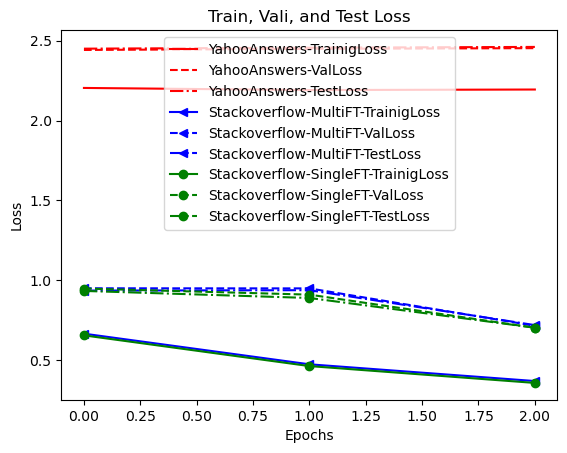

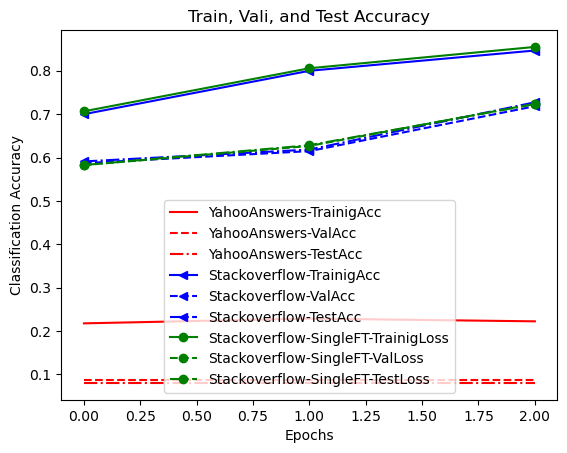

In [13]:
from matplotlib import pyplot as plt
import pickle
import numpy as np
# each touple has the following lists: (train_losses,train_accs,val_losses,val_accs,test_losses,test_accs)
with open('./Results/YahoAnswers.pickle', 'rb') as f:
    yahooAnswers = pickle.load(f)
with open('./Results/stackoverflow_multifinetuning.pickle', 'rb') as f:
    stackoverfelow_multifinetuned = pickle.load(f)
with open('./Results/stackoverflow_finetuned.pickle', 'rb') as f:
    stackoverfelow_finetuned = pickle.load(f)

losses = []
accuracies = []


x = np.arange(len(yahooAnswers[0]))
#plotting train, val, test losses
plt.plot(x,yahooAnswers[0],'r-',label='YahooAnswers-TrainigLoss')
plt.plot(x,yahooAnswers[2],'r--',label='YahooAnswers-ValLoss')
plt.plot(x,yahooAnswers[4],'r-.',label='YahooAnswers-TestLoss')

plt.plot(x,stackoverfelow_multifinetuned[0],'b<-',label='Stackoverflow-MultiFT-TrainigLoss')
plt.plot(x,stackoverfelow_multifinetuned[2],'b<--',label='Stackoverflow-MultiFT-ValLoss')
plt.plot(x,stackoverfelow_multifinetuned[4],'b<-.',label='Stackoverflow-MultiFT-TestLoss')

plt.plot(x,stackoverfelow_finetuned[0],'go-',label='Stackoverflow-SingleFT-TrainigLoss')
plt.plot(x,stackoverfelow_finetuned[2],'go--',label='Stackoverflow-SingleFT-ValLoss')
plt.plot(x,stackoverfelow_finetuned[4],'go-.',label='Stackoverflow-SingleFT-TestLoss')

plt.title('Train, Vali, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')

plt.figure()
x = np.arange(len(yahooAnswers[1]))
#plotting train, val, test losses
plt.plot(x,yahooAnswers[1],'r-',label='YahooAnswers-TrainigAcc')
plt.plot(x,yahooAnswers[3],'r--',label='YahooAnswers-ValAcc')
plt.plot(x,yahooAnswers[5],'r-.',label='YahooAnswers-TestAcc')

plt.plot(x,stackoverfelow_multifinetuned[1],'b<-',label='Stackoverflow-TrainigAcc')
plt.plot(x,stackoverfelow_multifinetuned[3],'b<--',label='Stackoverflow-ValAcc')
plt.plot(x,stackoverfelow_multifinetuned[5],'b<-.',label='Stackoverflow-TestAcc')

plt.plot(x,stackoverfelow_finetuned[1],'go-',label='Stackoverflow-SingleFT-TrainigLoss')
plt.plot(x,stackoverfelow_finetuned[3],'go--',label='Stackoverflow-SingleFT-ValLoss')
plt.plot(x,stackoverfelow_finetuned[5],'go-.',label='Stackoverflow-SingleFT-TestLoss')

plt.title('Train, Vali, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Classification Accuracy')
plt.legend()
plt.savefig('acc.png')

    